
# **Image Colorization With GANs**


## **1. Downloading and Processing the data**

>Tập dữ liệu là ảnh màu để huấn luyện mô hình GAN, ở đây em dùng hình ảnh chủ yếu về mèo, ảnh với các **màu chủ đạo là nâu, vàng , xám.**

>Tải xuống tập dữ liệu [từ đây](https://drive.google.com/file/d/1LNskZbMPdnWZ42JEB83BeTpY8tSWK2Ft/view?usp=sharing).

>Tập dữ liệu gồm 5000 Ảnh.

In [ ]:
# Kết nối với Google Drive từ Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


[Thư mục trên Google Drive](https://drive.google.com/drive/folders/1ET9AGGOmyhAJKq_N8JVjd5QLIkqXj_xq?usp=sharing)

In [ ]:
!unzip /content/drive/MyDrive/To_Mau_Anh_Xam/GAN/Data_Cat/Data_Cat.zip

unzip:  cannot find or open /content/drive/MyDrive/To_Mau_Anh_Xam/GAN/Data_Cat/Data_Cat.zip, /content/drive/MyDrive/To_Mau_Anh_Xam/GAN/Data_Cat/Data_Cat.zip.zip or /content/drive/MyDrive/To_Mau_Anh_Xam/GAN/Data_Cat/Data_Cat.zip.ZIP.


>Bây giờ sẽ phân tích các hình ảnh (chính xác là hình ảnh RGB) và chuyển đổi từng hình ảnh thành hình ảnh thang độ xám bằng cách sử dụng phương pháp `.convert ('L')` của PIL. Vì vậy, tập dữ liệu của em sẽ có các mẫu (***hình ảnh thang độ xám, hình ảnh RGB***)

>Em chỉ sử dụng một phần tập dữ liệu của mình, được xác định bởi `dataset_split`.


In [ ]:
from PIL import Image
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np
from keras.utils.vis_utils import plot_model
from matplotlib import image
from matplotlib import pyplot as plt
import os
import time
import tensorflow as tf
from tensorflow import keras
tf.config.run_functions_eagerly(True)

In [ ]:
# The batch size we'll use for training
batch_size = 64

# Size of the image required to train our model
img_size = 120

# These many images will be used from the data archive
dataset_split = 5000

master_dir = '/content/Data_Cat'
x = []
y = []
for image_file in os.listdir( master_dir )[ 0 : dataset_split ]:
    rgb_image = Image.open( os.path.join( master_dir , image_file ) ).resize( ( img_size , img_size ) )
    # Normalize the RGB image array
    rgb_img_array = (np.asarray( rgb_image ) ) / 255
    gray_image = rgb_image.convert( 'L' )
    # Normalize the grayscale image array
    gray_img_array = ( np.asarray( gray_image ).reshape( ( img_size , img_size , 1 ) ) ) / 255
    # Append both the image arrays
    x.append( gray_img_array )
    y.append( rgb_img_array )

# Train-test splitting
train_x, test_x, train_y, test_y = train_test_split( np.array(x) , np.array(y) , test_size=0.1 )

# Construct tf.data.Dataset object
dataset = tf.data.Dataset.from_tensor_slices( ( train_x , train_y ) )
dataset = dataset.batch( batch_size )



## **2. The GAN**

Trong phần này, em sẽ tạo mô hình GAN từng bước với Keras. Đầu tiên, sẽ triển khai mô hình sinh ( Generator ), sau đó là mô hình phân biệt ( Discriminator )và cuối cùng là các hàm mất mát ( Loss Function ) cho cả hai.



### **A. Generator** 


>Mô hình sinh ( Generator ) ( được đại diện là $G$ ) sẽ nhận hình ảnh thang độ xám $x$ và tạo ra hình ảnh RGB $G( x )$. Lưu ý, $x$ sẽ là một tensor có hình dạng $( \ batch \ size \ , \ 120 \ , \ 120 \ , \ 1 \ )$ và đầu ra $G( x )$ sẽ có hình dạng $( \ batch \ size \ , \ 120 \ , \ 120 \ , \ 3 \ )$

>- Mô hình sinh ( Generator )sẽ có cấu trúc bộ mã hóa-giải mã, tương tự như kiến ​​trúc UNet. Ngoài ra, chúng tôi sử dụng các tập hợp được pha loãng để có trường tiếp nhận lớn hơn.
- Giới thiệu các kết nối bỏ qua trong mô hình của mình để có luồng thông tin tốt hơn từ bộ mã hóa đến bộ giải mã.


In [ ]:
def get_generator_model():

    inputs = tf.keras.layers.Input( shape=( img_size , img_size , 1 ) )

    conv1 = tf.keras.layers.Conv2D( 16 , kernel_size=( 5 , 5 ) , strides=1 )( inputs )
    conv1 = tf.keras.layers.LeakyReLU()( conv1 )
    conv1 = tf.keras.layers.Conv2D( 32 , kernel_size=( 3 , 3 ) , strides=1)( conv1 )
    conv1 = tf.keras.layers.LeakyReLU()( conv1 )
    conv1 = tf.keras.layers.Conv2D( 32 , kernel_size=( 3 , 3 ) , strides=1)( conv1 )
    conv1 = tf.keras.layers.LeakyReLU()( conv1 )

    conv2 = tf.keras.layers.Conv2D( 32 , kernel_size=( 5 , 5 ) , strides=1)( conv1 )
    conv2 = tf.keras.layers.LeakyReLU()( conv2 )
    conv2 = tf.keras.layers.Conv2D( 64 , kernel_size=( 3 , 3 ) , strides=1 )( conv2 )
    conv2 = tf.keras.layers.LeakyReLU()( conv2 )
    conv2 = tf.keras.layers.Conv2D( 64 , kernel_size=( 3 , 3 ) , strides=1 )( conv2 )
    conv2 = tf.keras.layers.LeakyReLU()( conv2 )

    conv3 = tf.keras.layers.Conv2D( 64 , kernel_size=( 5 , 5 ) , strides=1 )( conv2 )
    conv3 = tf.keras.layers.LeakyReLU()( conv3 )
    conv3 = tf.keras.layers.Conv2D( 128 , kernel_size=( 3 , 3 ) , strides=1 )( conv3 )
    conv3 = tf.keras.layers.LeakyReLU()( conv3 )
    conv3 = tf.keras.layers.Conv2D( 128 , kernel_size=( 3 , 3 ) , strides=1 )( conv3 )
    conv3 = tf.keras.layers.LeakyReLU()( conv3 )

    bottleneck = tf.keras.layers.Conv2D( 128 , kernel_size=( 3 , 3 ) , strides=1 , activation='tanh' , padding='same' )( conv3 )

    concat_1 = tf.keras.layers.Concatenate()( [ bottleneck , conv3 ] )
    conv_up_3 = tf.keras.layers.Conv2DTranspose( 128 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu' )( concat_1 )
    conv_up_3 = tf.keras.layers.Conv2DTranspose( 128 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu' )( conv_up_3 )
    conv_up_3 = tf.keras.layers.Conv2DTranspose( 64 , kernel_size=( 5 , 5 ) , strides=1 , activation='relu' )( conv_up_3 )

    concat_2 = tf.keras.layers.Concatenate()( [ conv_up_3 , conv2 ] )
    conv_up_2 = tf.keras.layers.Conv2DTranspose( 64 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu' )( concat_2 )
    conv_up_2 = tf.keras.layers.Conv2DTranspose( 64 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu' )( conv_up_2 )
    conv_up_2 = tf.keras.layers.Conv2DTranspose( 32 , kernel_size=( 5 , 5 ) , strides=1 , activation='relu' )( conv_up_2 )

    concat_3 = tf.keras.layers.Concatenate()( [ conv_up_2 , conv1 ] )
    conv_up_1 = tf.keras.layers.Conv2DTranspose( 32 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu')( concat_3 )
    conv_up_1 = tf.keras.layers.Conv2DTranspose( 32 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu')( conv_up_1 )
    conv_up_1 = tf.keras.layers.Conv2DTranspose( 3 , kernel_size=( 5 , 5 ) , strides=1 , activation='relu')( conv_up_1 )

    model = tf.keras.models.Model( inputs , conv_up_1 )
    return model



### **B. Discriminator**

>Mô hình phân biệt ( Discriminator ), được biểu diễn là $D$, sẽ lấy hình ảnh thực $y$ (từ dữ liệu huấn luyện) và hình ảnh được tạo ra $G(x)$ (từ Mô hình sinh Generator ) để xuất ra hai xác suất.

>Đào tạo mô hình phân biệt theo cách có thể phân biệt hình ảnh thực và hình ảnh được tạo ra. Vì vậy, đào tạo mô hình sao cho y tạo ra output là $1.0$ và $G(x)$ tạo ra output là $0.0$.

>Lưu ý rằng thay vì sử dụng các nhãn cứng như $1.0$ và $0.0$, chúng ta sử dụng các nhãn mềm gần bằng 1 và 0. Vì vậy, đối với nhãn cứng $1.0$, nhãn mềm sẽ là $(1 - \epsilon)$ trong đó $\epsilon$ được chọn đồng nhất từ ​​$( 0 , 0.1 ]$


In [ ]:
def get_discriminator_model():
    layers = [
        tf.keras.layers.Conv2D( 32 , kernel_size=( 7 , 7 ) , strides=1 , activation='relu' , input_shape=( 120 , 120 , 3 ) ),
        tf.keras.layers.Conv2D( 32 , kernel_size=( 7, 7 ) , strides=1, activation='relu'  ),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D( 64 , kernel_size=( 5 , 5 ) , strides=1, activation='relu'  ),
        tf.keras.layers.Conv2D( 64 , kernel_size=( 5 , 5 ) , strides=1, activation='relu'  ),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D( 128 , kernel_size=( 3 , 3 ) , strides=1, activation='relu'  ),
        tf.keras.layers.Conv2D( 128 , kernel_size=( 3 , 3 ) , strides=1, activation='relu'  ),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D( 256 , kernel_size=( 3 , 3 ) , strides=1, activation='relu'  ),
        tf.keras.layers.Conv2D( 256 , kernel_size=( 3 , 3 ) , strides=1, activation='relu'  ),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense( 512, activation='relu'  )  ,
        tf.keras.layers.Dense( 128 , activation='relu' ) ,
        tf.keras.layers.Dense( 16 , activation='relu' ) ,
        tf.keras.layers.Dense( 1 , activation='sigmoid' ) 
    ]
    model = tf.keras.models.Sequential( layers )
    return model



### **C. Loss Functions**

>Bây giờ sẽ triển khai các hàm mất mát ( Loss Function ) cho mô hình GAN . Như đã biết chúng ta có hai hàm mất mát, một cho mô hình sinh và một cho mô hình phân biệt.

>- Đối với mô hình sinh , em sẽ sử dụng hàm mất mát L2 / MSE.
- Để tối ưu hóa, chúng tôi sử dụng trình tối ưu hóa Adam với tốc độ học là 0,0005



In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy()
mse = tf.keras.losses.MeanSquaredError()

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output) - tf.random.uniform( shape=real_output.shape , maxval=0.1 ) , real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output) + tf.random.uniform( shape=fake_output.shape , maxval=0.1  ) , fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output , real_y):
    real_y = tf.cast( real_y , 'float32' )
    return mse( fake_output , real_y )

generator_optimizer = tf.keras.optimizers.Adam( 0.0005 )
discriminator_optimizer = tf.keras.optimizers.Adam( 0.0005 )

generator = get_generator_model()
discriminator = get_discriminator_model()


In [ ]:
generator.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 120, 120, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_10 (Conv2D)             (None, 116, 116, 16  416         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 leaky_re_lu_9 (LeakyReLU)      (None, 116, 116, 16  0           ['conv2d_10[0][0]']              
                                )                                                           


## **3. Training The GAN**

Đào tạo GAN trên tập dữ liệu đà chuẩn bị trước đó.


In [ ]:
@tf.function
def train_step( input_x , real_y ):
   
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Generate an image -> G( x )
        generated_images = generator( input_x , training=True)
        # Probability that the given image is real -> D( x )
        real_output = discriminator( real_y, training=True)
        # Probability that the given image is the one generated -> D( G( x ) )
        generated_output = discriminator(generated_images, training=True)
        
        # L2 Loss -> || y - G(x) ||^2
        gen_loss = generator_loss( generated_images , real_y )
        # Log loss for the discriminator
        disc_loss = discriminator_loss( real_output, generated_output )
        
        losses["D"].append(disc_loss.numpy())
        losses["G"].append(gen_loss.numpy())
    #tf.keras.backend.print_tensor( tf.keras.backend.mean( gen_loss ) )
    #tf.keras.backend.print_tensor( gen_loss + disc_loss )
    
    # Compute the gradients
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # Optimize with Adam
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

generator.compile(optimizer='adam', loss='mse' , metrics=['accuracy'])
discriminator.compile(loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy'])


### Hình dung mô hình Sinh ( Generator ) và mô hình phân biệt ( Discriminator )


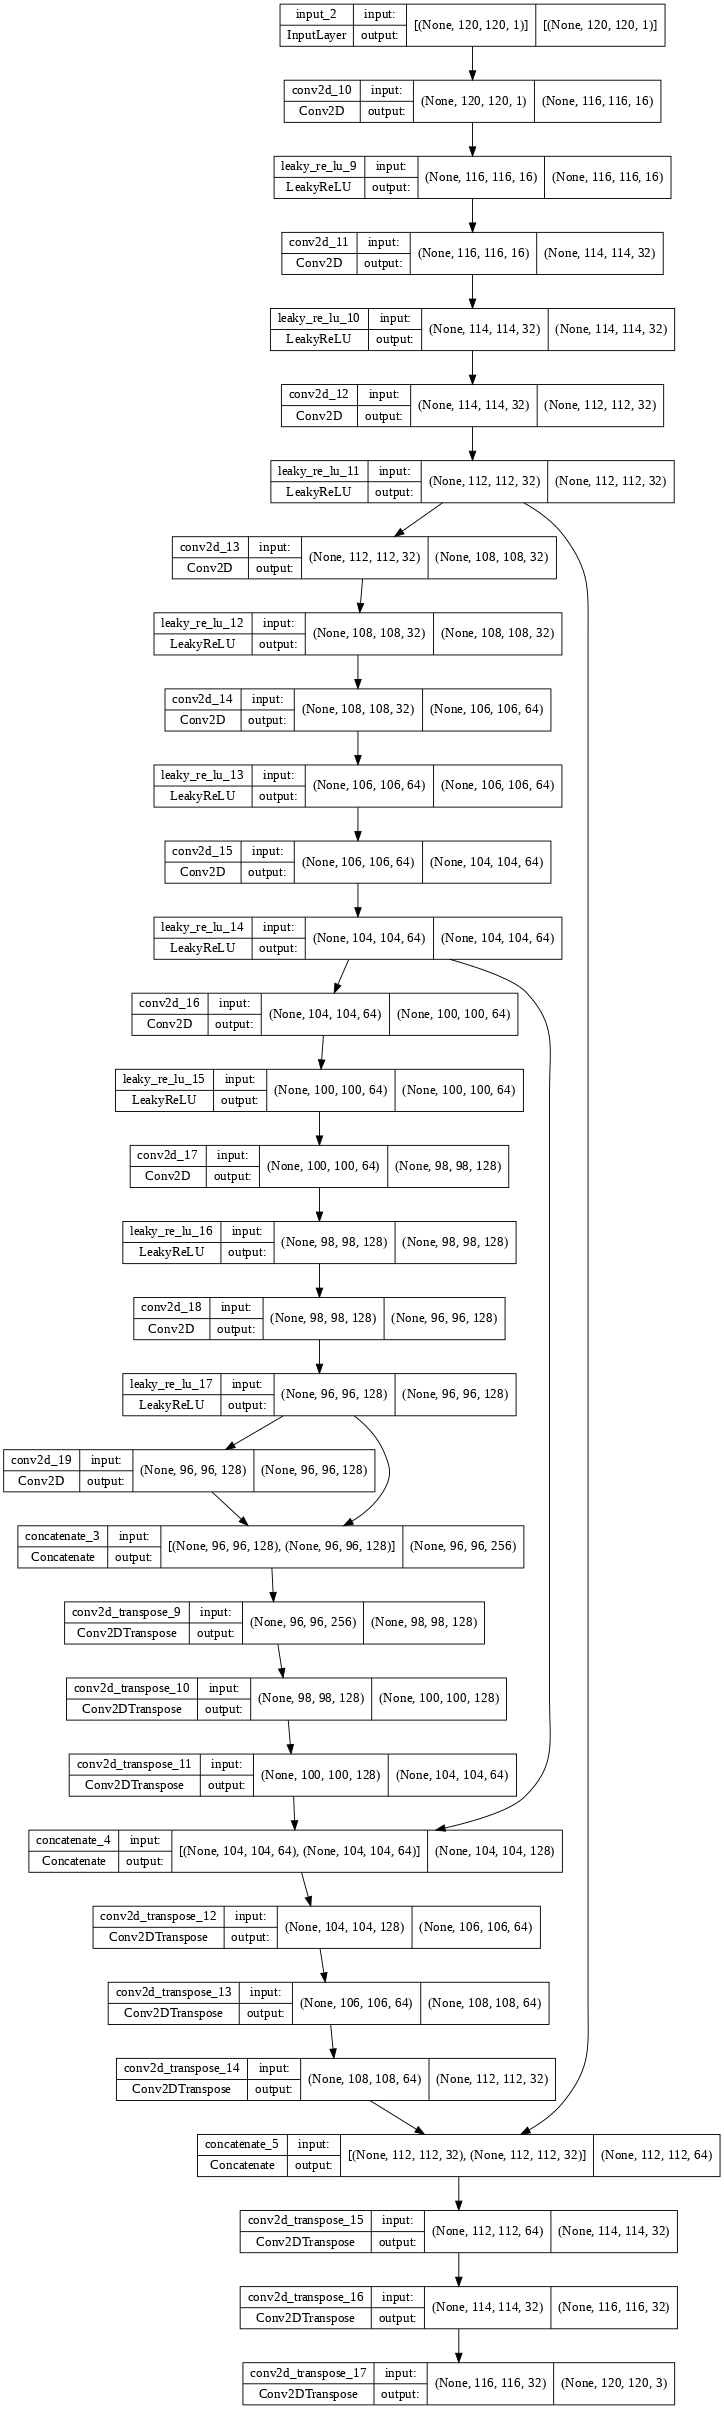

In [ ]:
plot_model(generator, to_file='generator.png', show_shapes=True, show_layer_names=True, dpi=66)

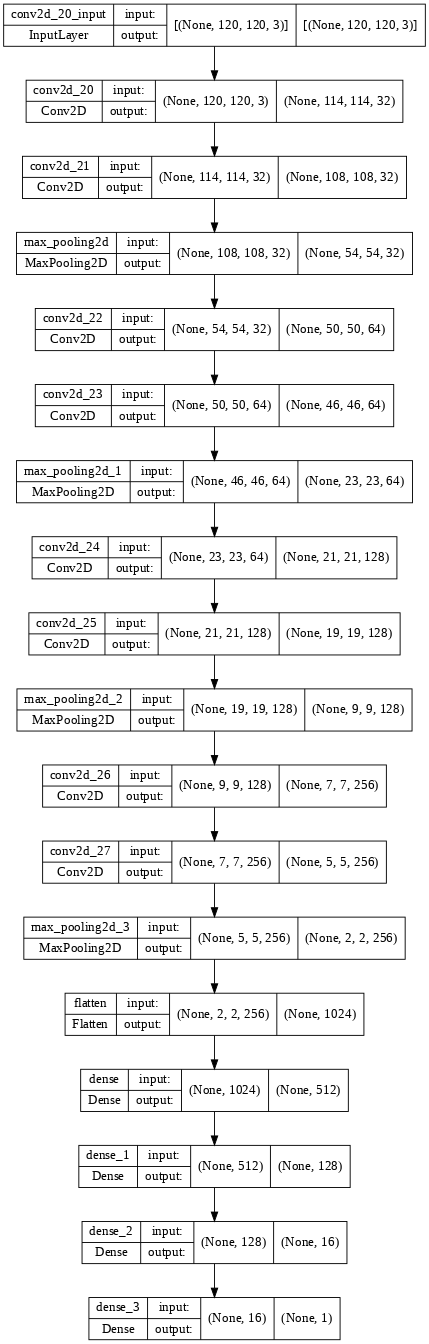

In [ ]:
plot_model(discriminator, to_file='discriminator.png', show_shapes=True, show_layer_names=True, dpi=66)

>Hàm để vẽ đồ thị mất mát của cả hai mô hình sinh và phân biệt

In [ ]:
def plot_loss(losses):
    """
    @losses.keys():
        0: loss
        1: accuracy
    """
    g_loss = []
    d_loss = []

    count = 0
    for i in losses['D']:
      count += 1
      if(count == 36):
        d_loss.append(i)
        count = 0

    count = 0   
    for i in losses['G']:
      count += 1
      if(count == 36):
        g_loss.append(i)
        count = 0

    plt.figure(figsize=(10,8))
    plt.plot(d_loss, label="Discriminator loss")
    plt.plot(g_loss, label="Generator loss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    print(d_loss)
    print(g_loss)

>Chạy ô bên dưới để bắt đầu quá trình đào tạo.

>Ở đây em sẽ chạy 50 epochs cho 1 lần và cứ 10 epochs sẽ tự động lưu lại mô hình sinh ( Generator ) và mô hình phân biệt ( Discriminator )

In [ ]:
path_save_model = '/content/drive/MyDrive/To_Mau_Anh_Xam/GAN/Data_Cat/Model/'
path_save_generator = ''
path_save_discriminator = ''

In [ ]:
# Please have a look at the Notebook in pdf form that was train on 150 epoc.
num_epochs = 50
save_interval=10
losses = {"D":[], "G":[]}
for e in range( num_epochs ):
    print("Running epoch : ", e )
    for ( x , y ) in dataset:
        # Here ( x , y ) represents a batch from our training dataset.
        # print( x.shape )
        train_step( x , y ) 
    if e % save_interval == 0:
      path_save_generator = path_save_model + 'Generator_Phu/generator_model_' + str(e) + '_5000.h5'
      generator.save(path_save_generator)
plot_loss(losses)


Running epoch :  32
Running epoch :  33
Running epoch :  34
Running epoch :  35
Running epoch :  36
Running epoch :  37
Running epoch :  38
Running epoch :  39
Running epoch :  40
Running epoch :  41
Running epoch :  42
Running epoch :  43
Running epoch :  44
Running epoch :  45
Running epoch :  46
Running epoch :  47
Running epoch :  48
Running epoch :  49


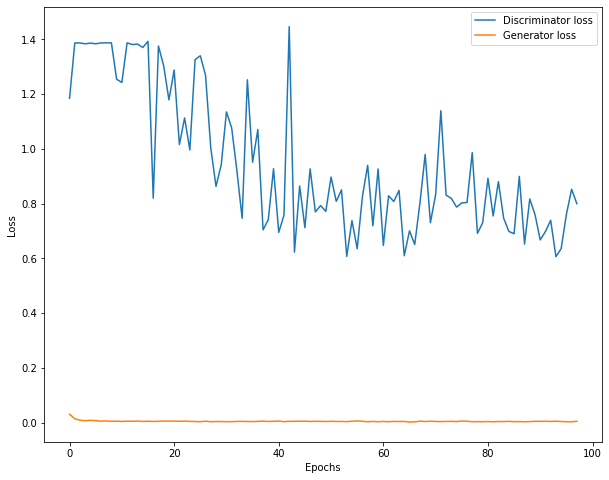

[1.1847489, 1.3868098, 1.3864644, 1.3834844, 1.3859645, 1.3836106, 1.386458, 1.3870022, 1.3869472, 1.2541656, 1.2421455, 1.3870841, 1.3807839, 1.382323, 1.370147, 1.3923876, 0.8196517, 1.3753487, 1.3024955, 1.178687, 1.2875509, 1.0155236, 1.112765, 0.99597234, 1.3258266, 1.3397527, 1.2689371, 1.0033839, 0.86294, 0.94174516, 1.1348497, 1.0759754, 0.9194511, 0.74616456, 1.252025, 0.95096475, 1.0702763, 0.7038796, 0.74144685, 0.9272016, 0.6949118, 0.757601, 1.4459642, 0.6228014, 0.86432683, 0.7116767, 0.9267647, 0.7695231, 0.79270995, 0.7718067, 0.8969394, 0.8080577, 0.8500155, 0.60701823, 0.73764944, 0.6349819, 0.82563835, 0.9396962, 0.71889126, 0.9262072, 0.6471387, 0.82847476, 0.8076412, 0.8479816, 0.6094967, 0.7005392, 0.6507535, 0.8026446, 0.979715, 0.73007154, 0.832695, 1.1392176, 0.83057916, 0.8191747, 0.7871777, 0.8025367, 0.80400467, 0.9857681, 0.6912951, 0.73039854, 0.8924051, 0.7548336, 0.8802713, 0.7468841, 0.698485, 0.689736, 0.8993075, 0.6521667, 0.81684196, 0.75994563, 0.66

In [ ]:
# # Please have a look at the Notebook in pdf form that was train on 150 epoc.
# num_epochs = 50
# losses = {"D":[], "G":[]}
# for e in range( num_epochs ):
#   print("Running epoch : ", e )
#   for ( x , y ) in dataset:
#     # Here ( x , y ) represents a batch from our training dataset.
#     # print( x.shape )
#     train_step( x , y )
#   path_save_discriminator = path_save_model + 'Discriminator/discriminator_model_' + str(e) + '_5000.h5'
#   path_save_generator = path_save_model + 'Generator/generator_model_' + str(e) + '_5000.h5'
#   discriminator.save(path_save_discriminator)
#   generator.save(path_save_generator)

# plot_loss(losses)


Để kiểm tra kết quả:
- đầu tiên load lên mô hình sinh ( Generator )
- sử dụng tập test đã chia từ trước đó để hiện kết quả

In [ ]:
new_generator = tf.keras.models.load_model('/content/drive/MyDrive/To_Mau_Anh_Xam/GAN/Data_Cat/Model/Generator/generator_model_47_5000.h5')

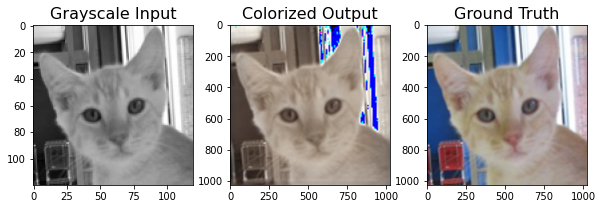

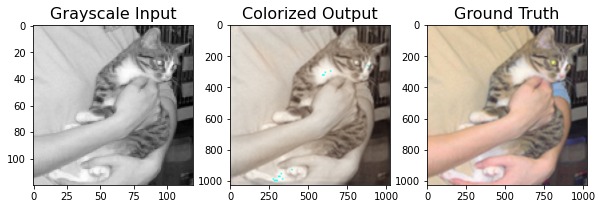

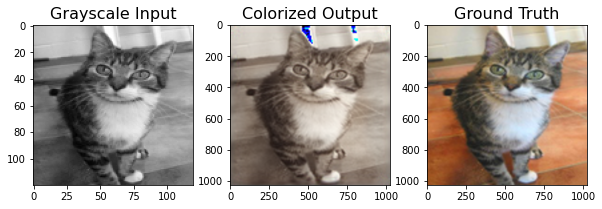

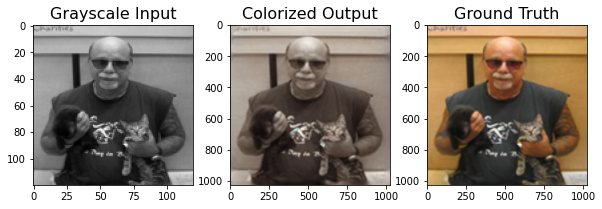

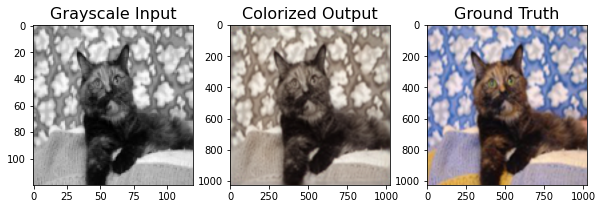

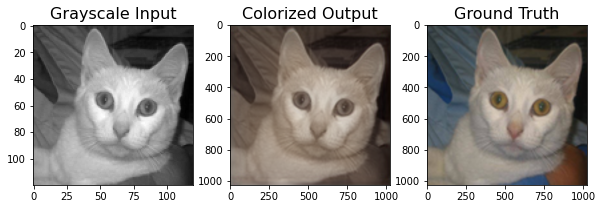

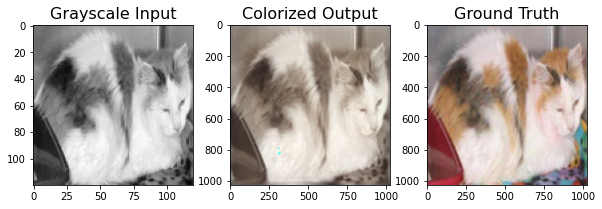

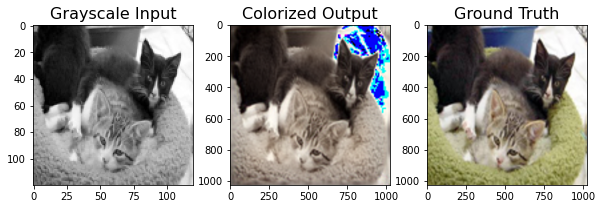

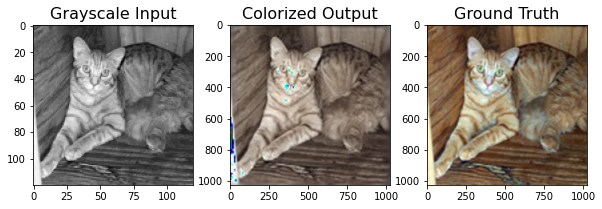

In [ ]:
y = new_generator( test_x[0 : 10] ).numpy()
for i in range(1, 10, 1):
  plt.figure(figsize=(10,10))
  or_image = plt.subplot(3,3,1)
  or_image.set_title('Grayscale Input', fontsize=16)
  plt.imshow( test_x[i].reshape((120,120)) , cmap='gray' )

  in_image = plt.subplot(3,3,2)    
  image = Image.fromarray( ( y[i] * 255 ).astype( 'uint8' ) ).resize( ( 1024 , 1024 ) )
  image = np.asarray( image )
  in_image.set_title('Colorized Output', fontsize=16)
  plt.imshow( image )

  ou_image = plt.subplot(3,3,3)
  image = Image.fromarray( ( test_y[i] * 255 ).astype( 'uint8' ) ).resize( ( 1024 , 1024 ) )
  ou_image.set_title('Ground Truth', fontsize=16)
  plt.imshow( image )

  plt.show()

![anh_ket_qua_1](https://i.pinimg.com/564x/59/bd/05/59bd051527111c2bde721bbd8acb78bf.jpg)

## **4. Training Next**

Để tiếp tục đào tạo từ mô hình có sẵn trước đó. Vì Colab giới hạn thời gian cho mỗi lần chạy.

In [ ]:
from keras.models import load_model
new_discriminator = tf.keras.models.load_model('/content/drive/MyDrive/To_Mau_Anh_Xam/GAN/Model/discriminator_model_49_5000.h5')
new_generator = tf.keras.models.load_model('/content/drive/MyDrive/To_Mau_Anh_Xam/GAN/Model/generator_model_49_5000.h5')
discriminator.trainable = False


In [ ]:
@tf.function
def train_step2( input_x , real_y ):
   
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Generate an image -> G( x )
        generated_images = new_generator( input_x , training=True)
        # Probability that the given image is real -> D( x )
        real_output = new_discriminator( real_y, training=True)
        # Probability that the given image is the one generated -> D( G( x ) )
        generated_output = new_discriminator(generated_images, training=True)
        
        # L2 Loss -> || y - G(x) ||^2
        gen_loss = generator_loss( generated_images , real_y )
        # Log loss for the discriminator
        disc_loss = discriminator_loss( real_output, generated_output )
        
        losses["D"].append(disc_loss.numpy())
        losses["G"].append(gen_loss.numpy())
    #tf.keras.backend.print_tensor( tf.keras.backend.mean( gen_loss ) )
    #tf.keras.backend.print_tensor( gen_loss + disc_loss )
    
    # Compute the gradients
    gradients_of_generator = gen_tape.gradient(gen_loss, new_generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, new_discriminator.trainable_variables)

    # Optimize with Adam
    generator_optimizer.apply_gradients(zip(gradients_of_generator, new_generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, new_discriminator.trainable_variables))

new_generator.compile(optimizer='adam', loss='mse' , metrics=['accuracy'])
discriminator.compile(loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy'])


Running epoch :  33
Running epoch :  34
Running epoch :  35
Running epoch :  36
Running epoch :  37
Running epoch :  38
Running epoch :  39
Running epoch :  40
Running epoch :  41
Running epoch :  42
Running epoch :  43
Running epoch :  44
Running epoch :  45
Running epoch :  46
Running epoch :  47
Running epoch :  48
Running epoch :  49
Running epoch :  50


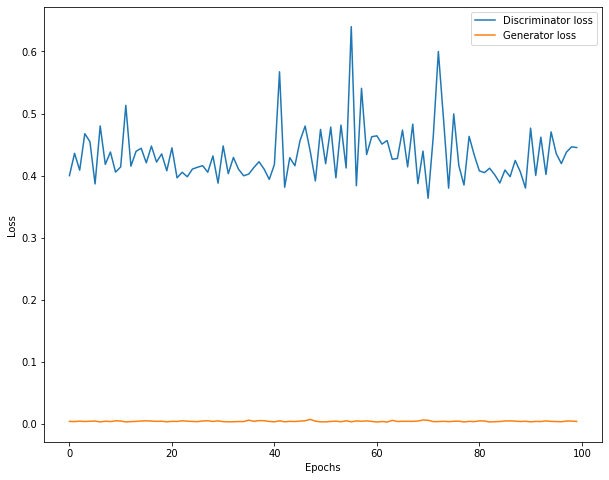

[0.3999299, 0.43583316, 0.40866092, 0.4675343, 0.45461312, 0.38652864, 0.48002583, 0.41802517, 0.43798915, 0.40554932, 0.4139687, 0.51319474, 0.4151785, 0.43906873, 0.44409382, 0.42057163, 0.4475605, 0.42179397, 0.4349402, 0.40773332, 0.4447173, 0.39640743, 0.40535295, 0.39812934, 0.4105001, 0.41346765, 0.41591594, 0.40541607, 0.43163764, 0.38782045, 0.44779137, 0.40306798, 0.42925906, 0.41023934, 0.39971665, 0.40246844, 0.41311067, 0.42231977, 0.41036296, 0.39385417, 0.41786507, 0.56730294, 0.3812238, 0.42885578, 0.41589504, 0.45626712, 0.47984454, 0.4388435, 0.39136055, 0.47437453, 0.41917259, 0.47816047, 0.39635193, 0.48136356, 0.41225982, 0.6399865, 0.38366765, 0.54065233, 0.4339926, 0.4626472, 0.46409667, 0.45077586, 0.45645997, 0.42630267, 0.4275207, 0.47332746, 0.41399646, 0.48297, 0.387023, 0.43944645, 0.36337394, 0.46241382, 0.59998643, 0.49175483, 0.3798069, 0.49942774, 0.41595823, 0.3847947, 0.46326584, 0.4331099, 0.40756983, 0.40477484, 0.41187805, 0.40128934, 0.38812432, 0

In [ ]:
num_epochs = 51
losses = {"D":[], "G":[]}
for e in range( num_epochs ):
    print("Running epoch : ", e )
    for ( x , y ) in dataset:
        # Here ( x , y ) represents a batch from our training dataset.
        # print( x.shape )
        train_step2( x , y )

        if (e %10 == 0):
        # trong thời gian chờ đợi mô hình đào tạo thì chịu khó vào đổi lại tên cho đỡ quên
          new_discriminator.save('/content/drive/MyDrive/To_Mau_Anh_Xam/GAN/Model/discriminator_model_{}_2_5000.h5')
          new_generator.save('/content/drive/MyDrive/To_Mau_Anh_Xam/GAN/Model/generator_model_{}_2_5000.h5')

plot_loss(losses)


## **5. Results**

Vẽ biểu đồ đầu vào, đầu ra và hình ảnh gốc tương ứng, từ một phần của tập dữ liệu để tìm ra kết quả.


In [ ]:
new_generator2 = tf.keras.models.load_model('/content/drive/MyDrive/To_Mau_Anh_Xam/GAN/Data_Cat/Model/Generator/generator_model_90_5000.h5')

In [ ]:
y1 = new_generator2( test_x[0 : 101] ).numpy()

In [ ]:
path_save_image = '/content/drive/MyDrive/To_Mau_Anh_Xam/GAN/Data_Cat/Colorization_image/Epochs_90/'
path_save_ground_truth = ''
path_save_colorized_output = ''

**lưu ảnh test của model**

>$tf.keras.utils.save_img(
    path, x, data_format=None, file_format=None, scale=True, **kwargs
)$


In [ ]:
for i in range(1, 401, 1):
  plt.figure(figsize=(10,10))
  or_image = plt.subplot(3,3,1)
  or_image.set_title('Grayscale Input', fontsize=16)
  plt.imshow( test_x[i].reshape((120,120)) , cmap='gray' )

  in_image = plt.subplot(3,3,2)    
  image2 = Image.fromarray( ( y1[i] * 255 ).astype( 'uint8' ) ).resize( ( 1024 , 1024 ) )
  image2 = np.asarray( image2 )
  in_image.set_title('Colorized Output', fontsize=16)
  path_save_colorized_output = path_save_image + 'Colorized_Output/colorized_cat_' + str(i) + '.jpg'
  tf.keras.utils.save_img(path_save_colorized_output, image2, data_format=None, file_format=None, scale=True)
  plt.imshow( image2 )

  ou_image = plt.subplot(3,3,3)
  image = Image.fromarray( ( test_y[i] * 255 ).astype( 'uint8' ) ).resize( ( 1024 , 1024 ) )
  ou_image.set_title('Ground Truth', fontsize=16)
  path_save_ground_truth = path_save_image + 'Ground_Truth/groundtruth_cat_' + str(i) + '.jpg'
  tf.keras.utils.save_img(path_save_ground_truth, image, data_format=None, file_format=None, scale=True)
  plt.imshow( image )

  plt.show()

Output hidden; open in https://colab.research.google.com to view.

## **6. Mean Squared Error ( MSE )**
>Mean Squared Error ( lỗi bình phương trung bình )

![Phương trình MSE](https://i.pinimg.com/564x/11/27/dc/1127dc258ac41b3c7357fd18f28e7de2.jpg)
I là ảnh gốc, K là ảnh mới.

>Một phương pháp phổ biến để kiểm tra định lượng hiệu ứng mà các thay đổi định dạng hoặc nén có thể có trên hình ảnh là sử dụng tỷ lệ tín hiệu trên nhiễu cao nhất $PSNR$, đó là tỷ lệ giữa công suất tối đa có thể của hình ảnh và sức mạnh của tiếng ồn bị hỏng ảnh hưởng đến chất lượng đại diện của nó. Tuy nhiên, có hai phương pháp khác cũng có thể sử dụng:

- MSE
- SSIM

>Giá trị của MSE gần bằng 0 là tốt hơn. Giá trị SSIM gần bằng 1 là giống với ảnh gốc



>Hàm MSE nhận hai đối số: hình ảnh và hình ảnh.( Xem các hình ảnh muốn so sánh để tìm sự giống nhau ).

>Đầu tiên, chuyển đổi hình ảnh từ số nguyên 8-bit không dấu sang dấu chấm động, theo cách đó không gặp bất kỳ vấn đề nào với các hoạt động mô-đun "quấn quanh". Sau đó, lấy sự khác biệt giữa các hình ảnh bằng cách trừ đi cường độ pixel. Tiếp theo, bình phương sự khác biệt này (do đó có nghĩa là sai số bình phương, và cuối cùng tổng chúng lại.

>Xử lý giá trị trung bình của Lỗi bình phương trung bình. Tất cả những gì chúng tôi đang làm là chia tổng số hình vuông của chúng tôi cho tổng số pixel trong hình ảnh. Cuối cùng, trả lại giá trị MSE.

>Điều quan trọng cần lưu ý là giá trị 0 của MSE cho thấy sự tương đồng hoàn hảo. Giá trị lớn hơn 1 giá trị có nghĩa là ít tương đồng hơn và sẽ tiếp tục tăng lên khi sự khác biệt trung bình giữa các cường độ pixel cũng tăng lên.

In [ ]:
def PSNR(original, compressed):
 mse = np.mean((original - compressed) ** 2)
 if(mse == 0):
  return 100
 max_pixel = 255.0
 psnr = 20 * log10(max_pixel / sqrt(mse))
 return psnr

In [ ]:
def mse(imageA, imageB):
	# the 'Mean Squared Error' between the two images is the
	# sum of the squared difference between the two images;
	# NOTE: the two images must have the same dimension
	err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
	err /= float(imageA.shape[0] * imageA.shape[1])
	
	# return the MSE, the lower the error, the more "similar"
	# the two images are
	return err

## **7.Structural Similarity Measure ( SSIM )**

>Structural Similarity Measure ( Chỉ số tương đồng cấu trúc )

![phương trình SSIM](https://i.pinimg.com/564x/f2/b6/3f/f2b63f34325c5201d4e010f45340564f.jpg)

>Chỉ số tương đồng cấu trúc ( $SSIM$ ) là một phương trình mới được phát triển vào năm 2004. Chỉ số đánh giá $SSIM$ dựa trên tính toán của ba yếu tố độ sáng ($l$), độ tương phản ($c$), và cấu trúc ($s$). Chỉ số tổng thể là sự kết hợp nhân lên của cả ba:

![](https://i.pinimg.com/564x/8f/8b/3b/8f8b3bb2166620b10bbc6bcd931263c3.jpg)

>Với:

![](https://i.pinimg.com/564x/56/7d/25/567d25c41edf6fc5e5d149e18b6e68cf.jpg)

>Trong đó μx, μy, σx, σy và σxy là các phương tiện cục bộ, độ lệch chuẩn và biến đổi chéo cho hình ảnh x,y. 

>Nếu  α = β = γ = 1 và C3 = C2/2 ( cả hai giả định phổ biến ) phương trình sẽ đơn giản hoá thành:

![phương trình SSIM](https://i.pinimg.com/564x/f2/b6/3f/f2b63f34325c5201d4e010f45340564f.jpg)

>Giá trị SSIM dao động từ 0 đến 1 trong đó 1 có nghĩa là một sự kết hợp hoàn hảo giữa ảnh gốc và bản sao ( hay ở đây em so sánh ảnh ground truth và ảnh colorized )

>Sử dụng hàm SSIM có sẵn trong scikit trong Python

## **8.Đánh Giá MSE SSIM PSNR**

In [ ]:
# import the necessary packages
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt
import numpy as np
import cv2
from math import log10, sqrt 
# import argparse

In [ ]:
mse_result = []
ssim_result = []
psnr_result = []

for i in range(1,101):
  path_save_ground_truth = path_save_image + 'Ground_truth/groundtruth_cat_' + str(i) + '.jpg'
  path_save_colorized_output = path_save_image + 'Colorized_output/colorized_cat_' + str(i) + '.jpg'

  ground_truth = cv2.imread(path_save_ground_truth)
  colorized_output = cv2.imread(path_save_colorized_output)
  p = PSNR(ground_truth, colorized_output)
  m = mse(ground_truth, colorized_output)
  s = ssim(ground_truth, colorized_output, multichannel=True)
  # setup the figure
  image_ground_truth = keras.preprocessing.image.load_img(path_save_ground_truth)
  image_colorized_output = keras.preprocessing.image.load_img(path_save_colorized_output)
  fig = plt.figure('Ground Truth vs Colorized Output')
  plt.suptitle("%d  -  PSNR: %.3f  -  MSE: %.3f  -  SSIM: %.3f" % (i, p, m, s))
	# show first image
  ax = fig.add_subplot(1, 2, 1)
  plt.imshow(image_colorized_output)
  plt.axis("off")
	# show the second image
  ax = fig.add_subplot(1, 2, 2)
  plt.imshow(image_ground_truth)
  plt.axis("off")
	# show the images
  plt.show()
  mse_result.append(m)
  ssim_result.append(s)
  psnr_result.append(p)


Output hidden; open in https://colab.research.google.com to view.

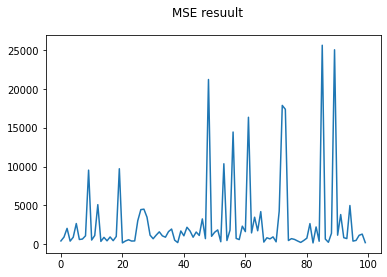

In [ ]:
plt.suptitle('MSE resuult')
plt.plot(mse_result)

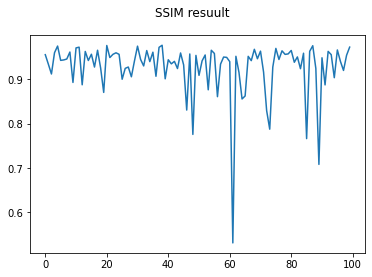

In [ ]:
plt.suptitle('SSIM resuult')
plt.plot(ssim_result)

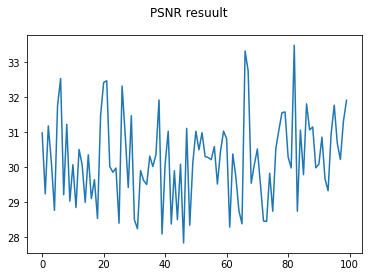

In [ ]:
plt.suptitle('PSNR resuult')
plt.plot(psnr_result)

## **9 Demo cho một ảnh**
Chạy riêng phần này


In [1]:
from google.colab import drive
drive.mount('/content/drive')
from PIL import Image
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np
from keras.utils.vis_utils import plot_model
from matplotlib import image
from matplotlib import pyplot as plt
import os
import time
import tensorflow as tf
from tensorflow import keras
tf.config.run_functions_eagerly(True)

Mounted at /content/drive


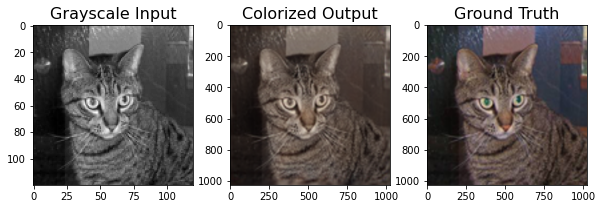

In [2]:
# voi Data_Cat thì epochs 90 la thay to tot voi:
# PSNR = 32.001
# MSE = 341.622
# SSIM = 0.956
i = 90 
path_link_image = '/content/drive/MyDrive/To_Mau_Anh_Xam/GAN/Data_Cat'
path_link_model = '/content/drive/MyDrive/To_Mau_Anh_Xam/GAN/Data_Cat/Model/Generator/generator_model_' + str(i) + '_5000.h5'
path_save_image = '/content/drive/MyDrive/To_Mau_Anh_Xam/GAN/Data_Cat/Example_colorization'
path_save_colorized_output = path_save_image + '/example_color_ep_' + str(i) + '_cat_1'+ '.jpg'


img_size = 120
x = []
y = []

rgb_image = Image.open( os.path.join( path_link_image , 'cat.1.jpg' ) ).resize( ( img_size , img_size ) )
rgb_img_array = (np.asarray( rgb_image ) ) / 255
gray_image = rgb_image.convert( 'L' )
gray_img_array = ( np.asarray( gray_image ).reshape( ( img_size , img_size , 1 ) ) ) / 255
x.append( gray_img_array )
y.append( rgb_img_array )
test_x = np.array(x)
test_y = np.array(y)

#load model
example_generator = tf.keras.models.load_model(path_link_model)

y = example_generator( test_x ).numpy()

plt.figure(figsize=(10,10))
or_image = plt.subplot(3,3,1)
or_image.set_title('Grayscale Input', fontsize=16)
plt.imshow( test_x.reshape((120,120)) , cmap='gray' )
in_image = plt.subplot(3,3,2)    
image = Image.fromarray( ( y[0]* 255 ).astype( 'uint8' ) ).resize( ( 1024 , 1024 ) )
image_co = np.asarray( image )
in_image.set_title('Colorized Output', fontsize=16)
plt.imshow( image_co )
ou_image = plt.subplot(3,3,3)
image = Image.fromarray( ( test_y[0] * 255 ).astype( 'uint8' ) ).resize( ( 1024 , 1024 ) )
ou_image.set_title('Ground Truth', fontsize=16)
plt.imshow( image )
plt.show()

# muốn lưu ảnh thì bật dòng code này 
# tf.keras.utils.save_img(path_save_colorized_output, image_co, data_format=None, file_format=None, scale=True)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
from PIL import Image
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np
from keras.utils.vis_utils import plot_model
from matplotlib import image
from matplotlib import pyplot as plt
import os
import time
import tensorflow as tf
from tensorflow import keras
tf.config.run_functions_eagerly(True)



# muốn lưu ảnh thì bật dòng code này 
# tf.keras.utils.save_img(path_save_colorized_output, image_co, data_format=None, file_format=None, scale=True)

Mounted at /content/drive


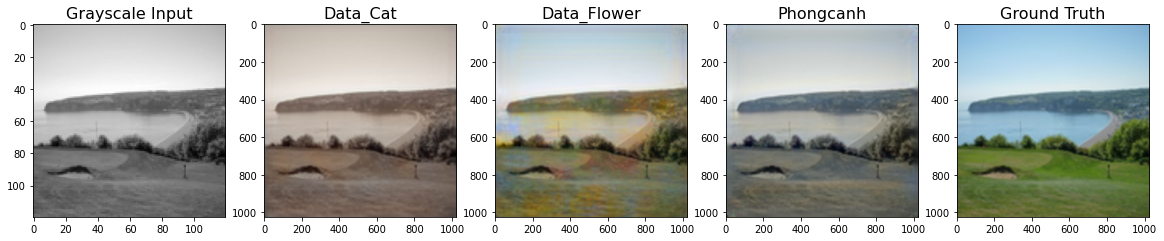

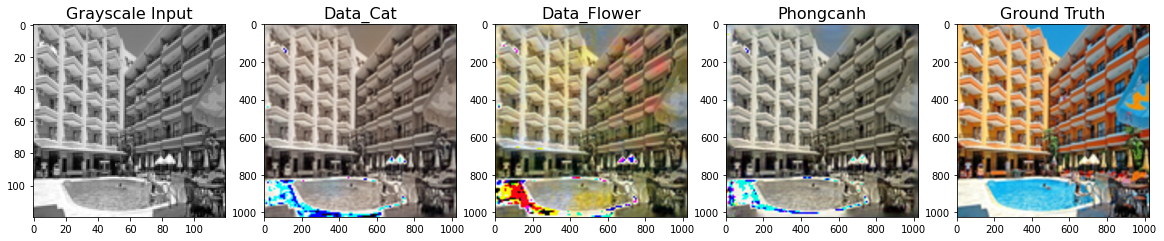

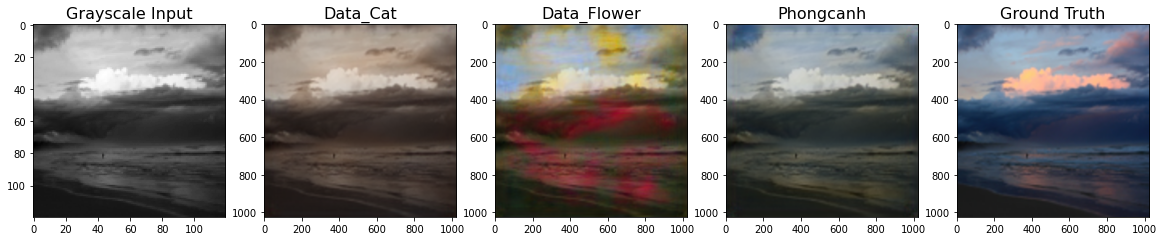

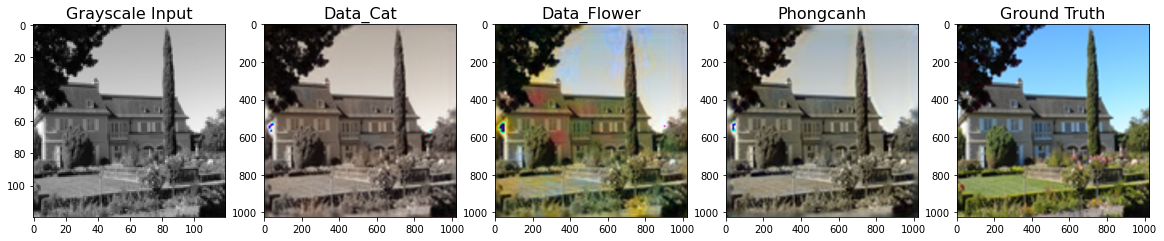

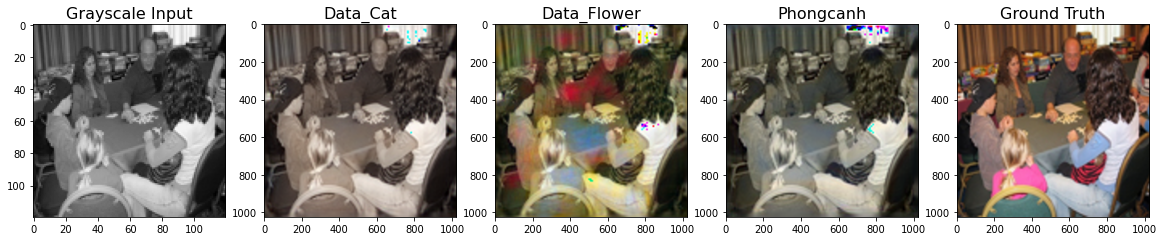

In [ ]:
i = 90 
j = 55
path_link_image = '/content/drive/MyDrive/To_Mau_Anh_Xam/GAN/Data_Cat'
path_link_model_cat = '/content/drive/MyDrive/To_Mau_Anh_Xam/GAN/Data_Cat/Model/Generator/generator_model_' + str(i) + '_5000.h5'
path_link_model_flower = '/content/drive/MyDrive/To_Mau_Anh_Xam/GAN/Data_Flower/Model/Generator/generator_model_' + str(j) + '_4000.h5'
path_link_model_phongcanh = '/content/drive/MyDrive/CSDL phongcanh/model/generator_model_140_1_2500.h5'
path_save_image = '/content/drive/MyDrive/To_Mau_Anh_Xam/GAN/Data_Cat/Example_colorization'
path_save_colorized_output = path_save_image + '/example_color_ep_' + str(i) + '_cat_1'+ '.jpg'

for k in range(1,6):
  img_size = 120
  x = []
  y = []
  name_image = 'image_' + str(k) + '.jpg'
  rgb_image = Image.open( os.path.join( path_link_image , name_image ) ).resize( ( img_size , img_size ) )
  rgb_img_array = (np.asarray( rgb_image ) ) / 255
  gray_image = rgb_image.convert( 'L' )
  gray_img_array = ( np.asarray( gray_image ).reshape( ( img_size , img_size , 1 ) ) ) / 255
  x.append( gray_img_array )
  y.append( rgb_img_array )
  test_x = np.array(x)
  test_y = np.array(y)

  #load model
  data_cat_generator = tf.keras.models.load_model(path_link_model_cat)
  data_flower_generator = tf.keras.models.load_model(path_link_model_flower)
  data_phongcanh_generator = tf.keras.models.load_model(path_link_model_phongcanh)


  y = data_cat_generator( test_x ).numpy()
  y_flower = data_flower_generator( test_x ).numpy()
  y_phongcanh = data_phongcanh_generator( test_x ).numpy()

  plt.figure(figsize=(20,20))
  or_image = plt.subplot(1,5,1)
  or_image.set_title('Grayscale Input', fontsize=16)
  plt.imshow( test_x.reshape((120,120)) , cmap='gray' )
  in_image = plt.subplot(1,5,2)    
  image = Image.fromarray( ( y[0]* 255 ).astype( 'uint8' ) ).resize( ( 1024 , 1024 ) )
  image_co = np.asarray( image )
  in_image.set_title('Data_Cat', fontsize=16)
  plt.imshow( image_co )
  in_image = plt.subplot(1,5,3)    
  image = Image.fromarray( ( y_flower[0]* 255 ).astype( 'uint8' ) ).resize( ( 1024 , 1024 ) )
  image_co = np.asarray( image )
  in_image.set_title('Data_Flower', fontsize=16)
  plt.imshow( image_co )
  in_image = plt.subplot(1,5,4)    
  image = Image.fromarray( ( y_phongcanh[0]* 255 ).astype( 'uint8' ) ).resize( ( 1024 , 1024 ) )
  image_co = np.asarray( image )
  in_image.set_title('Phongcanh', fontsize=16)
  plt.imshow( image_co )
  ou_image = plt.subplot(1,5,5)
  image = Image.fromarray( ( test_y[0] * 255 ).astype( 'uint8' ) ).resize( ( 1024 , 1024 ) )
  ou_image.set_title('Ground Truth', fontsize=16)
  plt.imshow( image )
  plt.show()